In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cumfreq
from scipy.interpolate import interp1d
from scipy.integrate import quad


# Second part: reservoir routing

#### list of parameter

In [2]:
# power plant
QT = 30 # [m^3 / s]
D = 3.6 # [m]
Lp = 1200 # [m]
ks = 0.5 # [mm]
eta = 0.75 # [-]
dz = 75 # [m]
lminHU = 9 # [m]

# river
Qlim = 100 # [m^3 / s]

# reservoir
Cqsl = 0.6 # [-]
Cqsp = 0.7 # [-]
Lspill = 140 # [m]
p = 19 # [m]

# water supply
Qcity = 1 # [m^3 / s]
etaP = 0.4 # [-]
etacrop = 0.8 # [-]
Acrop = 5 # [km^2]

# phyiscal parameters
rho = 1000 # [kg / m^3]
nu = 1e-6 # [m^2 / s]
g = 9.81 # [m / s^2]

In [37]:
# load generated discharge
Q = np.loadtxt('Q_gen.txt')
P = np.loadtxt('P_gen.txt') * 1e-3 / 3600
ET = np.loadtxt('ET_gen.txt') * 1e-3 / 3600

#### Minimum flow (DELIVERABLE 8)
We study the statistics of the geenrated discharges by plotting the discharge duration curve

In [7]:
# get cumulative histogram
res = cumfreq(Q, numbins=500)
bins = res.lowerlimit + np.linspace(0, res.binsize * res.cumcount.size, res.cumcount.size)
freq = res.cumcount / res.cumcount[-1]

<IPython.core.display.Javascript object>


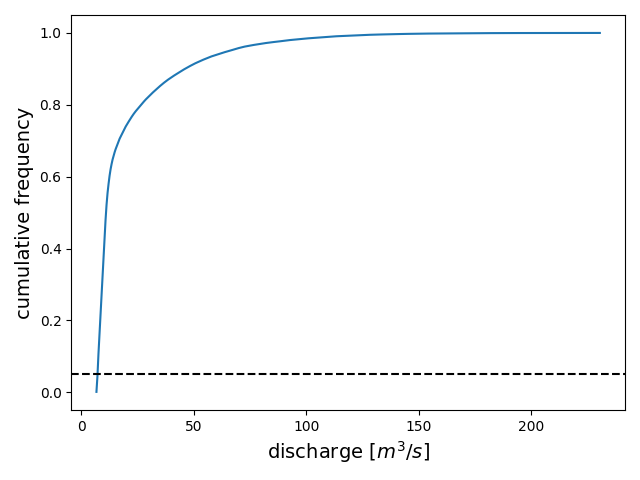

In [8]:
%matplotlib notebook

fig, ax = plt.subplots()

ax.plot(bins, freq)
ax.axhline(0.05, c='k', ls='--')

ax.set_xlabel(r'discharge $[m^3 / s]$', fontsize=14)
ax.set_ylabel(r'cumulative frequency', fontsize=14)

plt.tight_layout()

from the above plot, we read the minimum flow (discharge that is equalled or exceeded 95% of the time):

In [9]:
Q347 = 7.30 # [m^3 / s]

#### Volume rating curve (DELIVERABLE 7)
We compute the area and volume rating curves from the available data.

In [10]:
# load area rating curve
data = np.loadtxt('area_rating_curve.txt')
l = data[:, 0]
area = data[:, 1]

f_area = interp1d(l, area)
volume = [quad(f_area, 0, _l)[0] for _l in l] 
f_volume = interp1d(l, volume)
f_level = interp1d(volume, l)

<ipython-input-10-2933ff4a9f5d>:7: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  volume = [quad(f_area, 0, _l)[0] for _l in l]
<ipython-input-10-2933ff4a9f5d>:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  volume = [quad(f_area, 0, _l)[0] for _l in l]


<IPython.core.display.Javascript object>


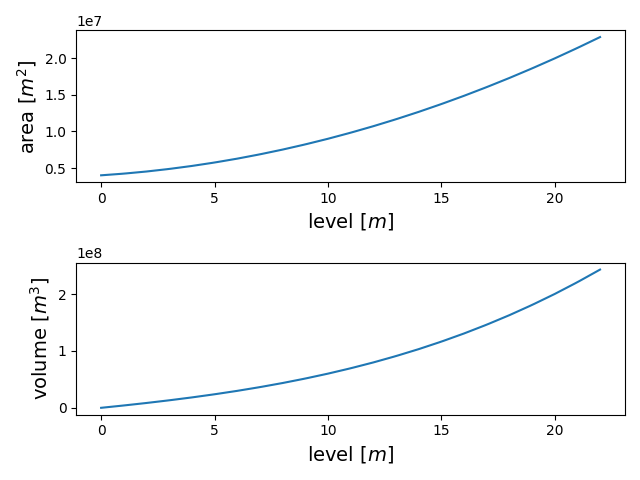

In [11]:
%matplotlib notebook

x = np.linspace(l.min(), l.max(), 100)
V = f_volume(x)
A = f_area(x)

fig, ax = plt.subplots(2)

ax[0].plot(x, A)
ax[1].plot(x, V)

ax[0].set_xlabel(r'level $[m]$', fontsize=14)
ax[0].set_ylabel(r'area $[m^2]$', fontsize=14)

ax[1].set_xlabel(r'level $[m]$', fontsize=14)
ax[1].set_ylabel(r'volume $[m^3]$', fontsize=14)

plt.tight_layout()

#### turbine functioning

The power plant produce a power $P = \eta \: \rho \: g \: h_T \: Q_{HU}$ where $h_T = l + dz - h_{loss}$ and $h_{loss} = \frac{1}{2} \frac{u^2}{2g} + \frac{u^2}{2g} + \frac{L_p}{D} f \frac{u^2}{2g}$ is the hydraulic head loss due to inlet, outlet and pipe friction. The friction coefficient $f$ is obtained by solving the Coolebrock equation grafically as below: 

<IPython.core.display.Javascript object>


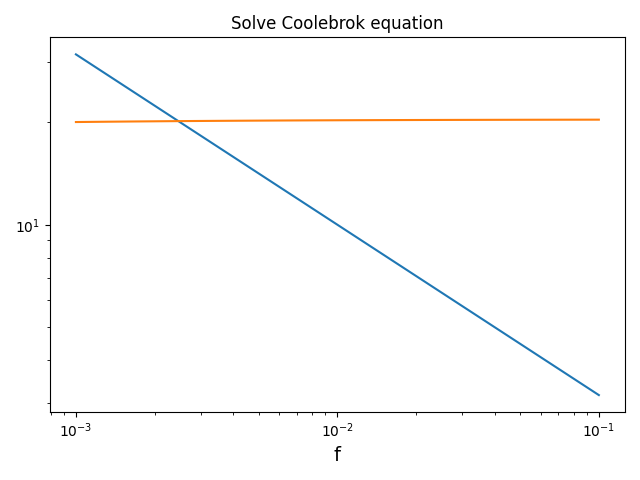

In [12]:
%matplotlib notebook

u = QT / (np.pi * (D / 2)**2) # [m / s]
nu = 1e-6 # [m^2 / s]
Re = u * D / nu

fig, ax = plt.subplots()

f = np.logspace(-3, -1)
y1 = f**-0.5
y2 = -2 * np.log((1e-3 * ks) / D / 3.7 + 2.51 / Re / f**.5)

ax.plot(f, y1)
ax.plot(f, y2)

ax.set_xlabel('f', fontsize=14)
ax.set(xscale='log', yscale='log')
plt.title('Solve Coolebrok equation')
plt.tight_layout()

from which we get:

In [13]:
f = 0.0024
hdrop = (0.5 + 1 + f * Lp / D) * u**2 / (2 * g)

#### reservoir routing

Implement the reservoir routing, namely the hourly evolution of water level following input discharge (Q), power plant supply (QHU), city supply (Qcity), crop fields supply (QI) and downstream discharge. 

In [65]:
def reservoir(Q, ET, P, l0, lmax, dt=3600, imax=None):
    
    Vmax = float(f_volume(lmax))

    data = {
        "volume": [float(f_volume(l0))],
        "level": [l0],
        "Qout": [],
        "QSUP": [],
        "power": [],
    }
    
    nsteps = len(Q)
    p1, p2 = False, False
    year = 0
    for i in range(nsteps):
        
        if i % (24 * 365) == 0:
            #print(year)
            year += 1

        V = data["volume"][-1]
        l = data["level"][-1]

        # power plant supply
        if i % 24 == 0:
            if l >= lmax:
                p1 = True
            else:
                p1 = False
                
        if i % 24 == 8:
            p2 = True
        if i % 24 == 21:
            p2 = False
            
        
        if p1 and p2:
            QHU = QT
        else:
            QHU = 0.
            
        hT = l + dz - hdrop 
        power = eta * rho * g * hT * QHU

        # crops and city supply
        QI = (ET[i] - etaP * P[i]) / etacrop * (1e6 * Acrop)
        QSUP = QI + Qcity

        # gate oppening
        Qg = max(Q347, min((V + (Q[i] - QHU - QSUP) * dt - Vmax) / dt, Qlim))
        A = Qg / (Cqsl * (2 * g * l)**.5)

        # output discharge
        if l <= p:
            Qout = Qg
        else:
            Qout = Qg + Cqsp * Lspill * (2 * g * (l - p)**3)**.5

        Vnew = V + (Q[i] - Qout - QHU - QSUP) * dt
        if Vnew <= 0:
            print(i)
        lnew = float(f_level(Vnew))
        
        
        data["volume"].append(Vnew)
        data["level"].append(lnew)
        data["Qout"].append(Qout)
        data["QSUP"].append(QSUP)
        data["power"].append(power)
        
        if imax is not None and i == imax:
            break
            
    data["volume"] = np.array(data["volume"][1:])
    data["level"] = np.array(data["level"][1:])
    data["Qout"] = np.array(data["Qout"])
    data["QSUP"] = np.array(data["QSUP"])
    data["power"] = np.array(data["power"])
    data["t"] = np.arange(imax + 1) / (24 * 365)    
        
    return data

Simulation of the above scenario over the generated 100 years for a maximum level for hydroelectric use of 15 m (**DELIVERABLE 9**):

In [66]:
l0 = 15
lmax = 17

hour_per_year = 24 * 365
nyear = 30
imax = nyear * hour_per_year
data = reservoir(Q, ET, P, l0, lmax, imax=imax)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


<IPython.core.display.Javascript object>


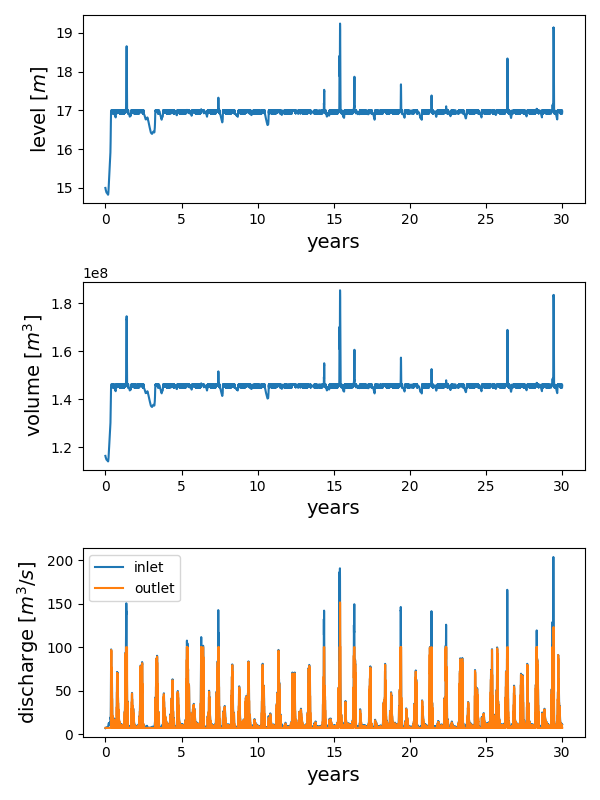

In [70]:
%matplotlib notebook

fig, ax = plt.subplots(3, figsize=(6, 8))

ax[0].plot(data["t"], data['level'])
ax[0].set_xlabel(r'years', fontsize=14)
ax[0].set_ylabel(r'level $[m]$', fontsize=14)

ax[1].plot(data["t"], data['volume'])
ax[1].set_xlabel(r'years', fontsize=14)
ax[1].set_ylabel(r'volume $[m^3]$', fontsize=14)

ax[2].plot(data["t"], Q[:imax+1], label=r'inlet')
ax[2].plot(data["t"], data['Qout'], label=r'outlet')
ax[2].set_xlabel(r'years', fontsize=14)
ax[2].set_ylabel(r'discharge $[m^3 / s]$', fontsize=14)
ax[2].legend()

plt.tight_layout()

In [71]:
l0 = 15
lmax = 15

hour_per_year = 24 * 365
nyear = 3

lmaxs = np.arange(9, 19, .2)
flood_probs = list()
mean_Eprods = list()
for lmax in lmaxs:
    data = reservoir(Q, ET, P, l0, lmax, imax=nyear * hour_per_year)

    annual_Eprod = np.array([sum(data['power'][i * hour_per_year:(i+1) * hour_per_year]) * 1e-9 for i in range(nyear)])
    mean_Eprods.append(annual_Eprod.mean())
    flood_probs.append((np.array(data['Qout']) > Qlim).mean())

0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3


<IPython.core.display.Javascript object>


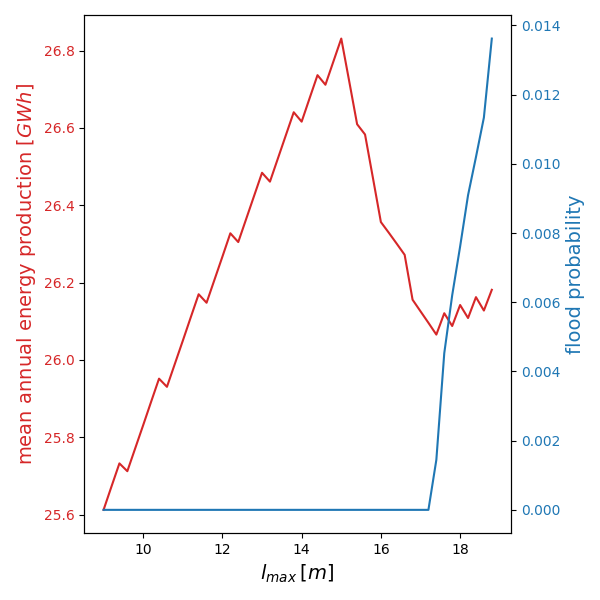

In [72]:
%matplotlib notebook

fig, ax1 = plt.subplots(figsize=(6, 6))

color = 'tab:red'
ax1.set_xlabel(r"$l_{max} \: [m]$", fontsize=14)
ax1.set_ylabel(r"mean annual energy production $[GWh]$", fontsize=14, color=color)
ax1.plot(lmaxs, mean_Eprods, c=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('flood probability', fontsize=14, color=color)
ax2.plot(lmaxs, flood_probs, c=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.tight_layout()

In [2]:
def f1(x, y):
    
    return 1 / (1 + 3 * (1 / x + 1 / y))

def f2(x, y):
    
    return 1 / (1 + 3 * (1 / x + 1 / y - 1 / (x + y)))

In [3]:
eps = 1e-3
ys = np.array([eps, 0.2, 0.4, 0.6, 0.8, 1 - eps])
xs = np.linspace(0, 1)

<IPython.core.display.Javascript object>


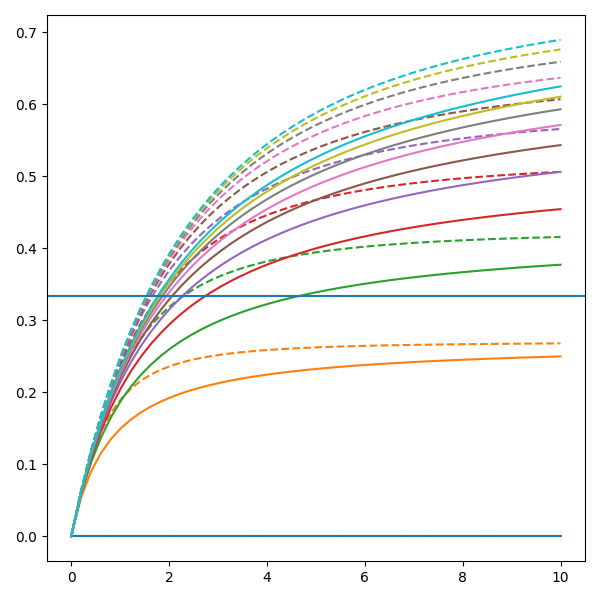

<ipython-input-2-ebd8ad38f344>:3: RuntimeWarning: divide by zero encountered in true_divide
  return 1 / (1 + 3 * (1 / x + 1 / y))
<ipython-input-2-ebd8ad38f344>:3: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 / (1 + 3 * (1 / x + 1 / y))
<ipython-input-2-ebd8ad38f344>:7: RuntimeWarning: divide by zero encountered in true_divide
  return 1 / (1 + 3 * (1 / x + 1 / y - 1 / (x + y)))
<ipython-input-2-ebd8ad38f344>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 / (1 + 3 * (1 / x + 1 / y - 1 / (x + y)))
<ipython-input-2-ebd8ad38f344>:7: RuntimeWarning: invalid value encountered in subtract
  return 1 / (1 + 3 * (1 / x + 1 / y - 1 / (x + y)))
<ipython-input-2-ebd8ad38f344>:3: RuntimeWarning: divide by zero encountered in true_divide
  return 1 / (1 + 3 * (1 / x + 1 / y))
<ipython-input-2-ebd8ad38f344>:7: RuntimeWarning: divide by zero encountered in true_divide
  return 1 / (1 + 3 * (1 / x + 1 / y - 1 / (x + y)))
<ipython-input-2-ebd8ad38

In [11]:
%matplotlib notebook

eps = 1e-3
ys = np.linspace(0, 10, 10)
xs = np.linspace(0, 10)

fig, ax = plt.subplots(figsize=(6, 6))

for i, y in enumerate(ys):
    ax.plot(xs, f1(xs, y), c='C{}'.format(i), ls='-')
    ax.plot(xs, f2(xs, y), c='C{}'.format(i), ls='--')

ax.axhline(1 / 3)

plt.tight_layout()